## Reproduction of Figure 2 (Baseline Comparison)

This notebook reproduces the venn diagram in Figure 2.

In [2]:
import sys
sys.path.append("../../scripts")
import json
import os 
import re
import glob
import pandas as pd
from collections import defaultdict
from evaluate_util import *

RESULT_PATH = '../../results/example2_n50.json'

project_name_map = {
    'Lang': 'Commons-lang',
    'Math': 'Commons-math',
    'Chart': 'JFreeChart',
    'Time': 'Joda-Time',
    'Mockito': 'Mockito'
}

target_projects = ['Time', 'Math', 'Lang', 'Chart', 'Mockito']

with open('../../data/Defects4J/invalid_bug_reports.txt') as f:
    invalid_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

with open(RESULT_PATH) as f:
    data = json.load(f)

eval_df = process_results_for_baseline(data)
aggr_eval_df = eval_df.groupby('bug_id').sum().reset_index()
aggr_eval_df['project'] = aggr_eval_df.bug_id.apply(lambda x: x.split('_')[0])

succeeded_bugs = aggr_eval_df[aggr_eval_df.success > 0]
valid_bugs = aggr_eval_df[aggr_eval_df.buggy_version_failing > 0]
target_aggr_eval_df = aggr_eval_df[aggr_eval_df.project.isin(target_projects)]

libro_success_allprojects = set(succeeded_bugs.bug_id.tolist())

with open('../../data/Defects4J/jcrashpack_d4j_targets.txt', 'r') as f:
    jcrashpack_targets = [line.strip().replace('-', '_') for line in f.readlines() if line.strip() not in invalid_bugs]

targets = set(target_aggr_eval_df.bug_id.tolist()).union(jcrashpack_targets)

print('# of bugs in target projects (Lang, Math, Chart, Mockito. Time):', len(targets))
print('# of crash bugs in target projects:', len(jcrashpack_targets))

# of bugs in target projects (Lang, Math, Chart, Mockito. Time): 206
# of crash bugs in target projects: 60


### Load baseline result: Copy&Paste, EvoCrash
* EvoCrash result on JCrashPack: https://zenodo.org/record/3766686#.Yw7_-OxBxqs

In [3]:
with open('../../data/baseline/copy_n_paste_result.json') as f:
    copynpaste_success_allprojects = json.load(f)

In [4]:
# EvoCrash result from buggy/fixed version executions

def file_prober(fname):
    with open(fname) as f:
        flines = f.readlines()
    
    look_for_exception = False
    exception_line = None
    for line in flines:
        if 'failure:' in line:
            look_for_exception = True
        if look_for_exception and re.match(r'.*: ', line) is not None:
            exception_line = line
            look_for_exception = False
    return exception_line

result_collater = defaultdict(lambda: ['', ''])
for fname in os.listdir('../../data/baseline/evocrash_test_results'):
    tname = fname.split('.')[0]
    collater_idx = int('fixed' in fname)
    exception_line = file_prober('../../data/baseline/evocrash_test_results/'+fname)
    result_collater[tname][collater_idx] = exception_line

reproducing = []
evocrash_success = []
total_bugs = []
for key in result_collater:
    buggy_exp, fixed_exp = result_collater[key]
    if buggy_exp != fixed_exp:
        reproducing.append(key)
        evocrash_success.append(key.split('#')[0])
    total_bugs.append(key.split('#')[0])

evocrash_success = set([b.replace('-', '_') for b in evocrash_success])
print('Reproduced:', evocrash_success, len(evocrash_success))


# Note: 5 bugs are neither contained in EvoCrash generation result 
# nor list of "reproduced" bugs (=has zero fitness test) of original EvoCrash result
# {'Lang_37', 'Lang_13', 'Math_3', 'Lang_20', 'Mockito_4'}

Reproduced: {'Lang_47', 'Time_5', 'Math_97', 'Lang_19', 'Math_38', 'Lang_51', 'Math_40', 'Math_8', 'Math_61', 'Math_98', 'Lang_33', 'Lang_12', 'Math_89', 'Math_100', 'Time_10', 'Math_70', 'Lang_39', 'Math_90', 'Lang_27', 'Math_84', 'Lang_45', 'Math_95', 'Time_2', 'Math_1', 'Lang_9', 'Math_79', 'Math_4', 'Math_81', 'Math_32'} 29


In [5]:
copynpaste_success = targets.intersection(copynpaste_success_allprojects)
evocrash_success = evocrash_success.intersection(targets)
libro_success = libro_success_allprojects.intersection(targets)
print(f'Reproduced Bugs by Ours: {len(libro_success)}')
# print(sorted(libro_success))

print(f'Reproduced Bugs by Evocrash: {len(evocrash_success)}')
# print(sorted(evocrash_success))


Reproduced Bugs by Ours: 108
Reproduced Bugs by Evocrash: 29


### (1) All crashes

In [6]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted, venn3_unweighted

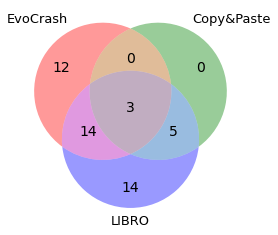

In [7]:
jcrashpack_targets = set(jcrashpack_targets)
out= venn3_unweighted([jcrashpack_targets.intersection(evocrash_success), jcrashpack_targets.intersection(copynpaste_success), jcrashpack_targets.intersection(libro_success)], ('EvoCrash', 'Copy&Paste', 'LIBRO'))
for text in out.set_labels:
    text.set_fontsize(13)
for text in out.subset_labels:
    text.set_fontsize(14)

plt.show()

### (2) With noncrashes 

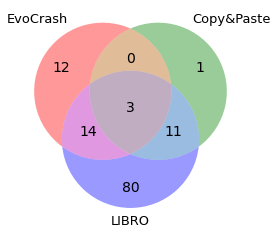

In [8]:
out = venn3_unweighted([set(evocrash_success), set(copynpaste_success), set(libro_success)], ('EvoCrash', 'Copy&Paste', 'LIBRO'))
for text in out.set_labels:
    text.set_fontsize(13)
for text in out.subset_labels:
    text.set_fontsize(14)

plt.show()

### (3) All Defects4J projects w/ bug reports

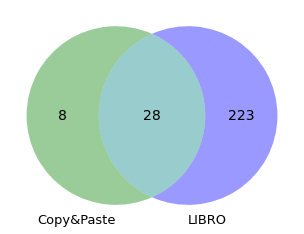

In [9]:
out = venn2_unweighted([set(copynpaste_success_allprojects), set(aggr_eval_df[aggr_eval_df.success > 0].bug_id.unique())], ('Copy&Paste', 'LIBRO'))
out.get_patch_by_id('10').set_color('green')
out.get_patch_by_id('01').set_color('blue')
out.get_patch_by_id('11').set_color('teal')
out.get_patch_by_id('11').set_alpha(0.4)
out.get_patch_by_id('10').set_edgecolor('none')
out.get_patch_by_id('01').set_edgecolor('none')
out.get_patch_by_id('11').set_edgecolor('none')

for text in out.set_labels:
    text.set_fontsize(13)
for text in out.subset_labels:
    text.set_fontsize(14)

plt.show()